In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/supply-chain-data/Supply chain logisitcs problem.xlsx


In [2]:
# Load data source

mainFile = pd.ExcelFile("/kaggle/input/supply-chain-data/Supply chain logisitcs problem.xlsx")
# reading in all from excel sheets.

# using dictionary to access all dataframe varaible easier.
df_dict = {}

for names in mainFile.sheet_names:  # returns a list of sheet names in the excel file.
    globals()[names] = mainFile.parse(names)
    df_dict[names] = globals()[names]
# show all keys    
df_dict.keys()

dict_keys(['OrderList', 'FreightRates', 'WhCosts', 'WhCapacities', 'ProductsPerPlant', 'VmiCustomers', 'PlantPorts'])

## Data Preparation and Transformation

In [3]:
# Print the shape of each dataframe
# Check and print - duplicates or missing values for each dataframe
for df_name, df in df_dict.items():
    print(df_name, '- shape:', df.shape)
    duplicate_count = df.duplicated().sum()
    missing_values_count = df.isnull().sum().sum()
    
    if duplicate_count > 0 or missing_values_count > 0:
        print(f">>>>{df_name} - duplicates: {duplicate_count}; missing values: {missing_values_count}")

OrderList - shape: (9215, 14)
FreightRates - shape: (1540, 11)
>>>>FreightRates - duplicates: 3; missing values: 0
WhCosts - shape: (19, 2)
WhCapacities - shape: (19, 2)
ProductsPerPlant - shape: (2036, 2)
VmiCustomers - shape: (14, 2)
PlantPorts - shape: (22, 2)


In [4]:
# drop duplicates
FreightRates = FreightRates.drop_duplicates()
# update dictionary
df_dict['FreightRates'] = FreightRates

In [5]:
# Rename columns by replacing spaces with underscores and '/', make them all uppercase.
for df_name, df in df_dict.items():
    df.columns = [col.strip().replace(' ', '_').replace('/', '_').upper() for col in df.columns]

In [6]:
# Update OrderList dataframe with cost calculation
orderList = df_dict['OrderList']  # Get the OrderList dataframe

# Merge OrderList with FreightRates and WhCosts on relevant columns
orderList = orderList.merge(df_dict['FreightRates'], left_on=['CARRIER', 'ORIGIN_PORT', 'DESTINATION_PORT'],
                            right_on=['CARRIER', 'ORIG_PORT_CD', 'DEST_PORT_CD'], how='left')
orderList = orderList.merge(df_dict['WhCosts'], left_on='PLANT_CODE', right_on='WH', how='left')

# Calculate the cost by multiplying unit quantity with the shipping rate and adding the storage cost
orderList['COST'] = (orderList['UNIT_QUANTITY'] * orderList['RATE']) + (orderList['UNIT_QUANTITY'] * orderList['COST_UNIT'])

# Perform detailed data preparation and transformation for OrderList dataframe
orderList = orderList.dropna()  # Drop rows with missing values
orderList['ORDER_DATE'] = pd.to_datetime(orderList['ORDER_DATE'])

# Perform additional data preparation and transformation for other dataframes
# Assuming you want to perform similar steps for ProductsPerPlant dataframe
productsPerPlant = df_dict['ProductsPerPlant']
productsPerPlant = productsPerPlant.dropna()  # Drop rows with missing values

# update dictionary values
df_dict['OrderList'] = orderList
df_dict['ProductsPerPlant'] = productsPerPlant

# Print the updated OrderList dataframe
orderList

,ORDER_ID,ORDER_DATE,ORIGIN_PORT,CARRIER,TPT,SERVICE_LEVEL,SHIP_AHEAD_DAY_COUNT,SHIP_LATE_DAY_COUNT,CUSTOMER,PRODUCT_ID,...,MAX_WGH_QTY,SVC_CD,MINIMUM_COST,RATE,MODE_DSC,TPT_DAY_CNT,CARRIER_TYPE,WH,COST_UNIT,COST
854,1.447385e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTP,31.2784,12.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,4713.804893
855,1.447385e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTD,31.2784,13.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5045.804893
856,1.447338e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTP,31.2784,12.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5082.958288
857,1.447338e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTD,31.2784,13.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5440.958288
858,1.447407e+09,2013-05-26,PORT09,V444_0,0,DTP,3,0,V555555_6,1692722,...,5000.00,DTP,31.2784,12.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5807.066871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209397,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,99.99,DTD,7.8044,0.0804,AIR,1.0,V888888883_1,PLANT03,0.517502,189.534900
209398,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,299.99,DTD,11.2272,0.0792,AIR,1.0,V888888883_1,PLANT03,0.517502,189.154500
209399,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,499.99,DTD,31.2672,0.0780,AIR,1.0,V888888883_1,PLANT03,0.517502,188.774100
209400,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,999.99,DTD,49.4272,0.0760,AIR,1.0,V888888883_1,PLANT03,0.517502,188.140100


In [7]:
# Check updated columns of all dataframes
for df_name, df in df_dict.items():
    print(f'Dataframe: {df_name} >>>')
    print('Columns:', df.columns.values)

Dataframe: OrderList >>>
Columns: ['ORDER_ID' 'ORDER_DATE' 'ORIGIN_PORT' 'CARRIER' 'TPT' 'SERVICE_LEVEL'
 'SHIP_AHEAD_DAY_COUNT' 'SHIP_LATE_DAY_COUNT' 'CUSTOMER' 'PRODUCT_ID'
 'PLANT_CODE' 'DESTINATION_PORT' 'UNIT_QUANTITY' 'WEIGHT' 'ORIG_PORT_CD'
 'DEST_PORT_CD' 'MINM_WGH_QTY' 'MAX_WGH_QTY' 'SVC_CD' 'MINIMUM_COST'
 'RATE' 'MODE_DSC' 'TPT_DAY_CNT' 'CARRIER_TYPE' 'WH' 'COST_UNIT' 'COST']
Dataframe: FreightRates >>>
Columns: ['CARRIER' 'ORIG_PORT_CD' 'DEST_PORT_CD' 'MINM_WGH_QTY' 'MAX_WGH_QTY'
 'SVC_CD' 'MINIMUM_COST' 'RATE' 'MODE_DSC' 'TPT_DAY_CNT' 'CARRIER_TYPE']
Dataframe: WhCosts >>>
Columns: ['WH' 'COST_UNIT']
Dataframe: WhCapacities >>>
Columns: ['PLANT_ID' 'DAILY_CAPACITY']
Dataframe: ProductsPerPlant >>>
Columns: ['PLANT_CODE' 'PRODUCT_ID']
Dataframe: VmiCustomers >>>
Columns: ['PLANT_CODE' 'CUSTOMERS']
Dataframe: PlantPorts >>>
Columns: ['PLANT_CODE' 'PORT']


## Statistics and Visualisation

In [8]:
df_dict['OrderList'].describe()

,ORDER_ID,TPT,SHIP_AHEAD_DAY_COUNT,SHIP_LATE_DAY_COUNT,PRODUCT_ID,UNIT_QUANTITY,WEIGHT,MINM_WGH_QTY,MAX_WGH_QTY,MINIMUM_COST,RATE,TPT_DAY_CNT,COST_UNIT,COST
count,2.085480e+05,208548.000000,208548.000000,208548.000000,2.085480e+05,208548.000000,208548.000000,208548.000000,208548.000000,208548.000000,208548.000000,208548.000000,208548.000000,208548.000000
mean,1.447273e+09,1.624374,1.931987,0.037881,1.680153e+06,2664.160021,16.350336,420.013605,12770.395519,9.900351,0.132569,2.096975,0.527681,1597.678289
std,8.414006e+04,0.496295,2.059308,0.313074,1.450609e+04,14966.032979,49.284847,628.169544,32193.967016,21.315896,0.272103,0.701241,0.056108,8684.093299
min,1.447126e+09,0.000000,0.000000,0.000000,1.613321e+06,235.000000,0.000000,0.000000,0.500000,1.202000,0.042400,0.000000,0.465071,122.905694
25%,1.447195e+09,1.000000,0.000000,0.000000,1.671942e+06,328.000000,1.404421,1.510000,99.990000,1.499200,0.048400,2.000000,0.517502,202.688741
50%,1.447273e+09,2.000000,1.000000,0.000000,1.683634e+06,437.000000,4.484133,100.000000,299.990000,3.455200,0.056400,2.000000,0.517502,305.286643
75%,1.447345e+09,2.000000,3.000000,0.000000,1.689547e+06,955.000000,13.080000,500.000000,1999.990000,3.455200,0.082400,3.000000,0.517502,634.937701
max,1.447425e+09,3.000000,6.000000,6.000000,1.702224e+06,561847.000000,2338.405126,2000.000000,99999.990000,101.827200,13.278400,3.000000,1.919808,337053.078104


In [9]:
df_dict['FreightRates'].describe()

,MINM_WGH_QTY,MAX_WGH_QTY,MINIMUM_COST,RATE,TPT_DAY_CNT
count,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000
mean,156.190905,4635.433438,12.300002,2.875135,2.188679
std,476.366708,20271.070359,22.959164,4.590475,2.002161
min,0.000000,0.453592,1.202000,0.033200,0.000000
25%,15.010000,21.500000,3.656800,0.451200,1.000000
50%,41.281408,47.500000,7.403200,1.656800,2.000000
75%,67.510000,75.000000,11.480000,3.916800,2.000000
max,10000.000000,99999.990000,425.027200,128.027200,14.000000


In [10]:
correlation_matrix = df_dict['OrderList'].corr(numeric_only=True).round(2)
correlation_matrix

,ORDER_ID,TPT,SHIP_AHEAD_DAY_COUNT,SHIP_LATE_DAY_COUNT,PRODUCT_ID,UNIT_QUANTITY,WEIGHT,MINM_WGH_QTY,MAX_WGH_QTY,MINIMUM_COST,RATE,TPT_DAY_CNT,COST_UNIT,COST
ORDER_ID,1.00,-0.02,-0.03,-0.03,0.03,0.01,0.00,-0.01,-0.01,0.01,0.01,-0.02,-0.01,0.01
TPT,-0.02,1.00,-0.13,0.06,-0.23,0.15,0.09,0.28,0.28,-0.40,-0.37,0.66,0.10,0.13
SHIP_AHEAD_DAY_COUNT,-0.03,-0.13,1.00,-0.02,0.08,-0.07,-0.01,-0.05,-0.05,0.07,0.06,-0.11,0.08,-0.07
SHIP_LATE_DAY_COUNT,-0.03,0.06,-0.02,1.00,-0.04,-0.01,-0.01,0.02,0.02,-0.03,-0.02,0.05,-0.02,-0.01
PRODUCT_ID,0.03,-0.23,0.08,-0.04,1.00,0.03,-0.04,-0.06,-0.06,0.09,0.09,-0.15,-0.09,0.03
UNIT_QUANTITY,0.01,0.15,-0.07,-0.01,0.03,1.00,0.43,0.03,0.03,-0.04,-0.03,0.06,-0.03,0.99
WEIGHT,0.00,0.09,-0.01,-0.01,-0.04,0.43,1.00,0.02,0.02,-0.02,0.02,0.04,0.05,0.43
MINM_WGH_QTY,-0.01,0.28,-0.05,0.02,-0.06,0.03,0.02,1.00,0.94,0.16,-0.19,0.20,-0.02,0.02
MAX_WGH_QTY,-0.01,0.28,-0.05,0.02,-0.06,0.03,0.02,0.94,1.00,-0.08,-0.12,0.21,-0.02,0.02
MINIMUM_COST,0.01,-0.40,0.07,-0.03,0.09,-0.04,-0.02,0.16,-0.08,1.00,-0.06,-0.30,0.03,-0.04


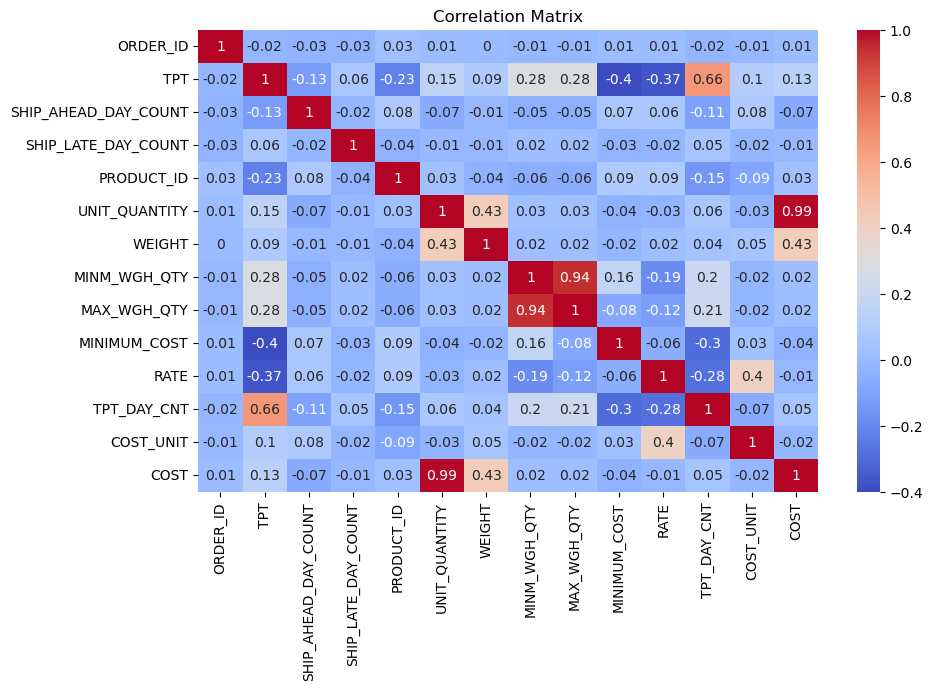

In [11]:
# plot correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Pricing and Revenue Data
pricing_strategy = df_dict['FreightRates']['MODE_DSC'].unique()
price_elasticity = df_dict['FreightRates']['RATE'].mean()
historical_revenue = df_dict['OrderList']['UNIT_QUANTITY'] * df_dict['OrderList']['COST']
total_revenue = historical_revenue.sum()
print("Pricing strategies:", pricing_strategy)
print("Average price elasticity:", price_elasticity)
print("Total historical revenue:", total_revenue)

Pricing strategies: ['AIR   ' 'GROUND']
Average price elasticity: 2.875135211279718
Total historical revenue: 27855522352652.188


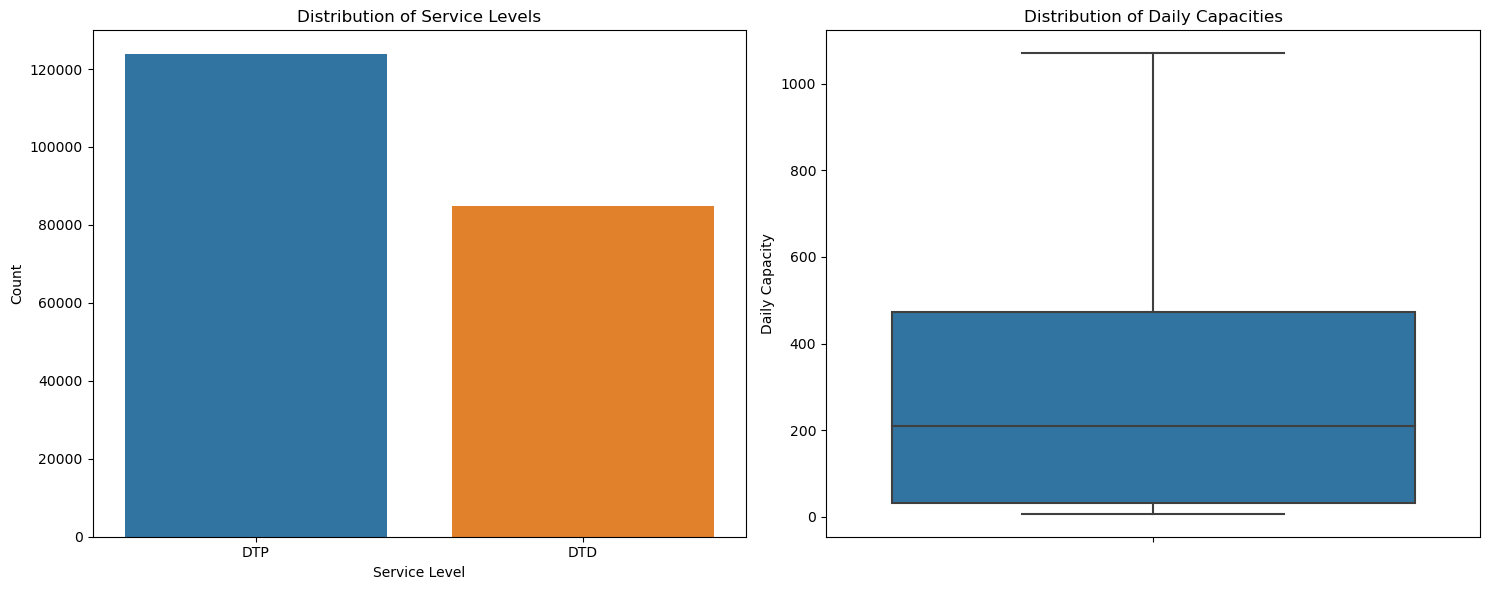

In [13]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of service levels (left subplot)
sns.countplot(data=df_dict['OrderList'], x='SERVICE_LEVEL', ax=axes[0])
axes[0].set_title('Distribution of Service Levels')
axes[0].set_xlabel('Service Level')
axes[0].set_ylabel('Count')

# Box plot of daily capacities (right subplot)
sns.boxplot(data=df_dict['WhCapacities'], y='DAILY_CAPACITY', ax=axes[1])
axes[1].set_title('Distribution of Daily Capacities')
axes[1].set_ylabel('Daily Capacity')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

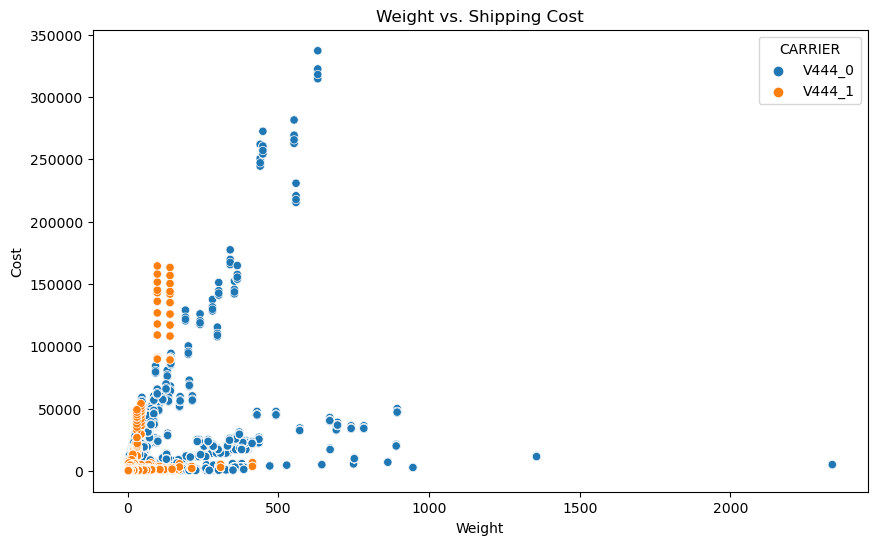

In [14]:
# Scatter plot of weight vs. shipping cost
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_dict['OrderList'], x='WEIGHT', y='COST', hue='CARRIER')
plt.title('Weight vs. Shipping Cost')
plt.xlabel('Weight')
plt.ylabel('Cost')
plt.show()

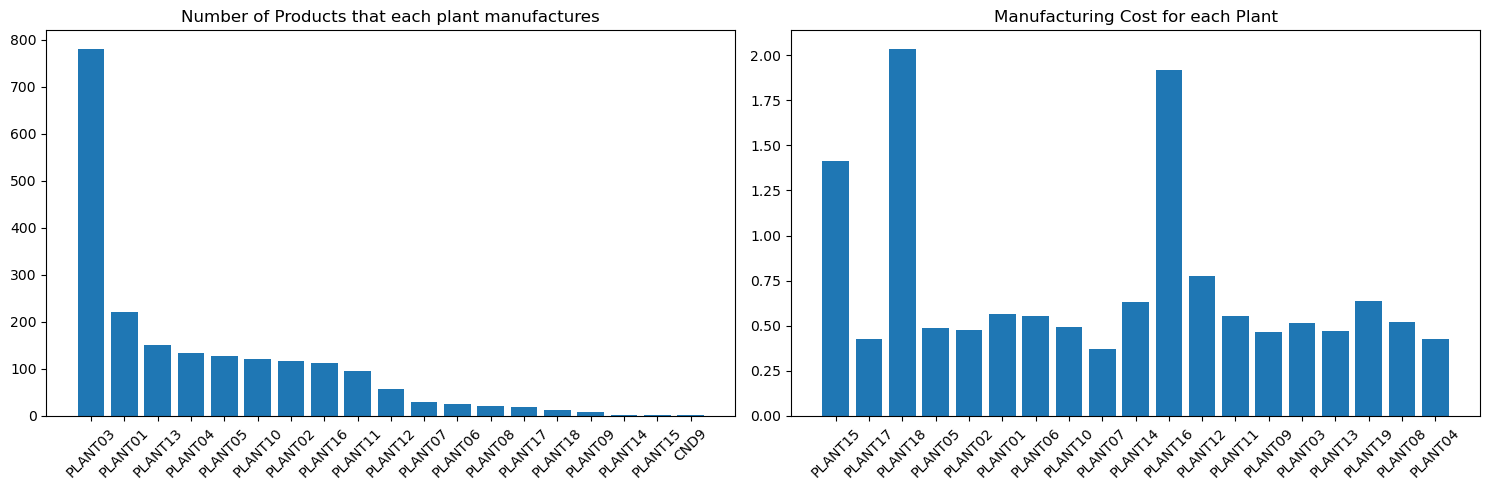

In [26]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Number of Products that each plant manufactures
plt.sca(axes[0])
plt.xticks(rotation=45)
plant_counts = pd.DataFrame(df_dict['ProductsPerPlant']['PLANT_CODE'].value_counts())
axes[0].bar(plant_counts.index, plant_counts["PLANT_CODE"])
axes[0].set_title("Number of Products that each plant manufactures")

# Plot Manufacturing Cost for each Plant
plt.sca(axes[1])
plt.xticks(rotation=45)
axes[1].bar(df_dict['WhCosts']['WH'], df_dict['WhCosts']["COST_UNIT"])
axes[1].set_title("Manufacturing Cost for each Plant")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Visualize the network/routing

In [25]:
import plotly.graph_objects as go

# Load the PlantPorts dataframe
df_plant_ports = df_dict['PlantPorts']

# Create the figure
fig = go.Figure()

# Add the connections as traces
for _, row in df_plant_ports.iterrows():
    fig.add_trace(
        go.Scatter(
            x = [row['PLANT_CODE'], row['PORT']],
            y = [1, 0],
            mode = 'lines+markers',
            marker = dict(
                size = 10,
                symbol = 'circle',
                line = dict(
                    color = 'blue',
                    width = 2
                )
            ),
            hoverinfo = 'text',
            text = f"Plant: {row['PLANT_CODE']}<br>Port: {row['PORT']}",
        )
    )

# Set up the layout
fig.update_layout(
    title_text = 'Plant and Port Connections',
    showlegend = False,
    xaxis = dict(
        title = 'PLANT_CODE - PORT',
        tickangle = -45
    ),
    yaxis = dict(
        title = '',
        showticklabels = False,
        range = [-0.2, 1.2]
    )
)

# Show the interactive plot
fig.show()

## Implement a Simple Linear Programming model

In [19]:
# Creates a list of all the supply nodes
supply_nodes = list(df_dict['WhCosts']['WH'])

# Creates a dictionary for the number of units of supply for each supply node
supply_dict = {}
for node in supply_nodes:
    total_capacity = sum(df_dict['WhCapacities']['DAILY_CAPACITY'][df_dict['WhCapacities']['PLANT_ID'] == node])
    supply_dict[node] = total_capacity

# Creates a list of all demand nodes
demand_nodes = list(df_dict['OrderList']['DESTINATION_PORT'].unique())

# Creates a dictionary for the number of units of demand for each demand node
demand_dict = {}
for index, row in df_dict['OrderList'].iterrows():
    dest_port = row['DESTINATION_PORT']
    unit_quantity = row['UNIT_QUANTITY']
    if dest_port in demand_dict:
        demand_dict[dest_port] += unit_quantity
    else:
        demand_dict[dest_port] = unit_quantity

In [20]:
# Creates a list of costs of each transportation path
costs = []
for index, row in df_dict['OrderList'].iterrows():
    carrier = row['CARRIER']
    orig_port = row['ORIG_PORT_CD']
    dest_port = row['DEST_PORT_CD']
    weight = row['WEIGHT']
    
    matching_rates = df_dict['FreightRates'][(df_dict['FreightRates']['CARRIER'] == carrier) &
                                  (df_dict['FreightRates']['ORIG_PORT_CD'] == orig_port) &
                                  (df_dict['FreightRates']['DEST_PORT_CD'] == dest_port) &
                                  (df_dict['FreightRates']['MINM_WGH_QTY'] <= weight) &
                                  (df_dict['FreightRates']['MAX_WGH_QTY'] >= weight)]['RATE']
    
    rate = matching_rates.values[0] if not matching_rates.empty else None
    costs.append(rate)

In [21]:
# Create a dictionary with supply nodes as keys, demand nodes as sub-keys, and costs as values
cost_dict = {}
for supply_node in supply_nodes:
    cost_dict[supply_node] = {}
    for demand_node in demand_nodes:
        cost_dict[supply_node][demand_node] = costs.pop(0)

In [22]:
# Import PuLP modeler functions
from pulp import *

# Creates the 'prob' variable to contain the problem data
prob = LpProblem("MaterialSupplyProblem", LpMinimize)

# Creates a list of tuples containing all the possible routes for transport
Routes = [(w, b) for w in supply_nodes for b in demand_nodes]

# A dictionary called 'Vars' is created to contain the referenced variables(the routes)
vars = LpVariable.dicts("Route", (supply_nodes, demand_nodes), 0, None, LpInteger)

# The minimum objective function is added to 'prob' first
prob += lpSum([vars[w][b] * cost_dict[w][b] for (w, b) in Routes]), "Sum_of_Transporting_Costs"


In [23]:
# The supply maximum constraints are added to prob for each supply node (warehouses)
for w in supply_nodes:
    prob += (
        lpSum([vars[w][b] for b in demand_nodes]) <= supply_dict[w],
        "Sum_of_Products_out_of_warehouses_%s" % w,
    )

# The demand minimum constraints are added to prob for each demand node (project)
for b in demand_nodes:
    prob += (
        lpSum([vars[w][b] for w in supply_nodes]) >= demand_dict[b],
        "Sum_of_Products_into_projects%s" % b,
    )

# Add constraint to avoid routes from a node to itself
for w in supply_nodes:
    for b in demand_nodes:
        if w != b:  # Check if supply node is different from demand node
            prob += (vars[w][b] >= 0, "No_Self_Transportation_%s_%s" % (w, b))
        else:
            prob += (vars[w][b] == 0, "No_Self_Transportation_%s_%s" % (w, b))
            vars[w][b].lowBound = 0  # Set lower bound to 0 for self-transportation


In [24]:
# The problem is solved using PuLP's choice of Solver
prob.solve()

# Print the variables optimized value
for v in prob.variables():
    print(v.name, "=", v.varValue)
    
# The optimised objective function value is printed to the screen
print("Value of Objective Function = ", value(prob.objective))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/2e405adbbc144a768a630f7be0abd04c-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/2e405adbbc144a768a630f7be0abd04c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 44 COLUMNS
At line 159 RHS
At line 199 BOUNDS
At line 219 ENDATA
Problem MODEL has 39 rows, 19 columns and 57 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.02

Route_PLANT01_PORT09 = 1070.0
Route_PLANT02_PORT09 = 138.0
Route_PLANT03_PORT09 = 555600470.0
Route_PLANT04_PORT09 = 554.0
Route_PLANT05_PORT09 = 385.0
Route_PLANT06_PORT09 = 49.0
Route_PLANT07_PORT09 = 265.0
Route_PLANT08_PORT09 = 14.0
Route_PLANT09_P

## Output Summary

The routing numbers indicate the quantities of products assigned to different routes from supply nodes to demand nodes. However, since the problem is infeasible, these numbers do not represent an actual feasible solution. The solver could not find a solution that satisfies all the constraints, such as supply and demand balancing.

